# [모듈 1.2] Semantic Textual Similarity 모델 추론 스크래치


---


# 1. Setup Environments
---


#### 사용자 정의 라이브러러 환경 셋업 및 라이브러리 로딩

In [1]:
import sys

In [2]:
%load_ext autoreload
%autoreload 2

sys.path.append('src')

In [3]:
%store -r model_save_path

In [4]:
import os
import sys
import json
import logging
import argparse
import torch
import gzip
import csv
import math
import urllib
from torch import nn
import numpy as np
import pandas as pd
from tqdm import tqdm

from datetime import datetime
from datasets import load_dataset
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, SentencesDataset, LoggingHandler, losses, models, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
# from sentence_transformers.readers import InputExample
# from transformers.trainer_utils import get_last_checkpoint

from os.path import exists

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    handlers=[LoggingHandler()]
)

logger = logging.getLogger(__name__)

# 2. Semantic Search (News)


시멘틱(의미) 검색은 검색 쿼리가 키워드를 찾는 것뿐만 아니라, 검색에 사용되는 단어의 의도와 문맥적 의미를 파악하는 것을 목표로 합니다.
시멘틱 유사도 검색을 또한 챗봇 및 해당 검색 쿼리를 입력하면, 검색 쿼리의 임베딩을 계산하여 모든 문서(예: 뉴스 제목/요약, 웹페이지 제목/요약) 리스트의 임베딩을 비교하여 가장 유사도가 높은 문서 후보들을 찾습니다.

References
- Billion-scale semantic similarity search with FAISS+SBERT: https://towardsdatascience.com/billion-scale-semantic-similarity-search-with-faiss-sbert-c845614962e2
- Korean Contemporary Corpus of Written Sentences: http://nlp.kookmin.ac.kr/kcc/

## 2.1. Preparing news dataset

In [5]:
class Params:
    def __init__(self):
        self.train_dir = 'data/KorSTS/train/'        
                        
args = Params()
print("train_dir: ", args.train_dir)

train_dir:  data/KorSTS/train/


In [6]:
from custom_util import MyProgressBar
from os.path import exists
import zipfile

news_path = f'{args.train_dir}/KCCq28_Korean_sentences_EUCKR_v2.txt'
print("news_path: \n", news_path, "\n")
    
if exists(news_path):
    print("Data is available")    
    pass
else:
    print("No data So we are downloading file")
    url = 'http://nlp.kookmin.ac.kr/kcc/KCCq28_Korean_sentences_EUCKR_v2.zip'
    news_path = f'{args.train_dir}/KCCq28_Korean_sentences_EUCKR_v2.zip'
    urllib.request.urlretrieve(url, news_path, MyProgressBar())    
    
    with zipfile.ZipFile(news_path, 'r') as zip_ref:
        zip_ref.extractall(train_dir)




news_path: 
 data/KorSTS/train//KCCq28_Korean_sentences_EUCKR_v2.txt 

Data is available


In [7]:
from custom_util import extract_news_data

news_data_raw = extract_news_data(args, news_path, logger)

2022-08-15 10:53:26 - news_data length:  1337721


## 2.2. News Data Sampling

- num_sample 을 에러시 조절 하세요.

In [8]:
num_sample = 20000

In [9]:
import random


def sample_news_data(num_sample, news_data_raw):
    random.seed(100)
    news_data = random.sample(news_data_raw, num_sample)
    #news_data = news_data_raw[:num_sample] # For debug purpose
    
    return news_data

corpus = sample_news_data(num_sample, news_data_raw)

In [10]:
corpus[0:3]

['그는 "터키 원전수주 계약은 일본 정부의 장기 위험 보증 조항에 달려 있다"고 덧붙였다.',
 '기재부 고위 관계자는 "김동연 부총리가 오고 지난해 예산안 통과 과정에서 예산실이 밤샘근무를 하루밖에 안 했다"며 "예산실장 출신이라 개선을 많이 하려고는 하는데 현장의 목소리를 더 들을 필요가 있다"고 꼬집었다.',
 '선수들을 지도하고 있는 원동현은 "이번 훈련을 통해 여자핸드볼 국가대표 선수들이 강인한 해병 정신으로 무장해 리우 올림픽에서 반드시 승리하도록 해병대가 견인차 역할을 할 것"이라며 "악조건 속에서도 전승을 거둬 온 해병대의 강한 훈련을 받은 만큼 선수들도 강한 자부심과 자신감을 갖게 될 것이라 확신한다"고 전했다.']

In [11]:
model = SentenceTransformer(model_save_path)

2022-08-15 10:53:26 - Load pretrained SentenceTransformer: /home/ec2-user/SageMaker/NLP-HuggingFace-On-SageMaker/3_Semantic-Textual-Similarity/3_Training/KorSTS/model/training_sts_sentence-transformers-xlm-r-100langs-bert-base-nli-stsb-mean-tokens-2022-08-15_07-09-03
2022-08-15 10:53:30 - Use pytorch device: cuda


## 2.3. 뉴스 데이터 Sentence-BERT Output Embedding

In [12]:
from custom_util import encode_multi_gpu_embedding 


corpus_embeddings = encode_multi_gpu_embedding(model, corpus) # 384 문장 임베딩 * 10,000 문장

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [13]:
from custom_util import semantic_search
from custom_util import Okt_tokenizer 

In [14]:
top_k = 5

queries = [
            '올 시즌 정규리그 35경기에서 23골을 작성한 손흥민은 이날 울버햄프턴을 상대로 득점에 \
            성공한 무함마드 살라흐(리버풀·23골)와 함께 정규리그 득점 공동 1위에 올랐다.\
            아시아 출신 선수가 EPL에서 득점왕에 오른 건 손흥민이 처음이다. \
            EPL뿐 아니라 유럽축구 5대 리그(잉글랜드·스페인·독일·프랑스·이탈리아)로 범위를 넓혀도 \
            아시아 선수 득점왕의 전례를 찾아보기 어렵다.'
          ]


### 2.3.1. Corpus: 원문, Query : 원문

In [15]:
# queries = [Okt_tokenizer(queries[0])]
semantic_search(model, corpus, corpus_embeddings, queries, top_k)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: 올 시즌 정규리그 35경기에서 23골을 작성한 손흥민은 이날 울버햄프턴을 상대로 득점에             성공한 무함마드 살라흐(리버풀·23골)와 함께 정규리그 득점 공동 1위에 올랐다.            아시아 출신 선수가 EPL에서 득점왕에 오른 건 손흥민이 처음이다.             EPL뿐 아니라 유럽축구 5대 리그(잉글랜드·스페인·독일·프랑스·이탈리아)로 범위를 넓혀도             아시아 선수 득점왕의 전례를 찾아보기 어렵다.

Top 5 most similar sentences in corpus:

(Score: 0.4953) 류 감독은 25일 대구구장에서 열린 SK 와이번스와의 2011 롯데카드 프로야구 한국시리즈 1차전에서 2-0으로 승리한 뒤 "우리 투수들이 잘 던졌다"고 칭찬했다.
(Score: 0.4525) 2009년 서울과 맨체스터 유나이티드의 친선경기에서는 두 골을 터트려 퍼거슨 맨유 감독으로부터 "10번 선수가 탐난다"는 찬사를 받기도 했다.
(Score: 0.4458) 한 일본 축구팬은 손흥민의 결승전 동점골을 두고 "역시 아시아의 에이스"라며 치켜세웠다.
(Score: 0.4457) 독일 토마스 뮐러가 전반 11분 페널티 킥을 성공시키자 그는 약 30초 동안 "골"을 외쳤다.
(Score: 0.4372) 동점골을 기록한 토트넘 공격수 해리 케인은 "손흥민의 골은 환상적이었다"고 칭찬했다.


### 2.3.2. Corpus: 원문, Query : 전처리, 토큰 (명사, 형용사)

In [16]:
queries = [Okt_tokenizer(queries[0])]
semantic_search(model, corpus, corpus_embeddings, queries, top_k)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: 시즌 정규 리그 경기 작성 손흥민 울버햄프턴 상대로 득점 성공하다 무함마드 살라 리버풀 정규 리그 득점 공동 아시아 출신 선수 득점 오른 손흥민 처음 아니다 유럽 축구 리그 잉글랜드 스페인 독일 프랑스 이탈리아 범위 아시아 선수 득점 전례 어렵다

Top 5 most similar sentences in corpus:

(Score: 0.5087) 영국 매체 스포츠 잉글리시는 이승우와 세 번째 골을 터뜨린 카를레스 알레나를 두고 "신비스러운 듀오"라고 칭찬했고 스페인 매체 마르카는 "클럽 최고의 두 선수인 이승우와 알레나가 득점을 책임졌다"고 전했다.
(Score: 0.4705) 2009년 서울과 맨체스터 유나이티드의 친선경기에서는 두 골을 터트려 퍼거슨 맨유 감독으로부터 "10번 선수가 탐난다"는 찬사를 받기도 했다.
(Score: 0.4676) 정재훈 롯데 이적, 이종운 감독 "최선의 선택"롯데가 두산과 FA 계약을 맺은 좌완 에이스 장원준을 지명했다.
(Score: 0.4661) 상대 에이스 로페즈를 상대로 7안타 2득점한 타선에 대해서도 "에이스를 상대로 대량득점을 기대할 수는 없지 않은가.꼭 필요한 점수를 얻어내는 SK다운 야구를 했다"고 호평했다.
(Score: 0.4645) 한 일본 축구팬은 손흥민의 결승전 동점골을 두고 "역시 아시아의 에이스"라며 치켜세웠다.


### 2.3.3 경제 뉴스

In [17]:
top_k = 5

queries = [
        '삼성전자의 2분기 확정 실적이 발표된 전일부터 이틀간 증권사 18곳에서 분석 보고서를 냈다.\
        대부분은 3분기가 더 부진할 것인 데다 주가는 한 차례 더 조정이 올 것이란 어두운 전망을 내놓았다.\
        우리나라 시총 1위 기업 주식이 이런데, 미국 장으로 옮기는 데 답인가, 어깨에서 사서 무릎에 팔게 생겼다' '호실적에도 떨어지고' '오늘도 기대했던 내가 바보다 \
        증권가도 떠나는 개미들을 붙잡을 만한 전망을 내놓지 못하는 상황이다. 하반기 실적은 더 암울할 것이라는 게 중론이어서다.'
        ]
# queries = [Okt_tokenizer(queries[0])]

semantic_search(model, corpus, corpus_embeddings, queries, top_k)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: 삼성전자의 2분기 확정 실적이 발표된 전일부터 이틀간 증권사 18곳에서 분석 보고서를 냈다.        대부분은 3분기가 더 부진할 것인 데다 주가는 한 차례 더 조정이 올 것이란 어두운 전망을 내놓았다.        우리나라 시총 1위 기업 주식이 이런데, 미국 장으로 옮기는 데 답인가, 어깨에서 사서 무릎에 팔게 생겼다호실적에도 떨어지고오늘도 기대했던 내가 바보다         증권가도 떠나는 개미들을 붙잡을 만한 전망을 내놓지 못하는 상황이다. 하반기 실적은 더 암울할 것이라는 게 중론이어서다.

Top 5 most similar sentences in corpus:

(Score: 0.6007) KDB대우증권 상품개발실 김희주 이사는 "한국 기업의 배당 성향은 전 세계적으로 가장 낮은 수준인 반면, 자본금 대비 배당가능이익은 역대 최고 수준으로 기업의 배당 여력은 충분하다"며 "최근 그룹 기업지배구조 개선 움직임과 더불어 향후 외국인·기관투자가 중심으로 배당 증대 압력이 커지고 있는 데다 정부 배당정책 모멘텀까지 가세해 배당주 투자에 새로운 변화가 예고된다"고 말했다.
(Score: 0.5407) 한 IB업계 관계자는 "단기실적이 급감할 경우 신용평가사에서 이를 곧바로 신용등급에 반영하는데다 최근 한 번에 두 단계, 혹은 한 해에도 두 차례 이상 등급을 강등하는 경우가 발생해 보유채권 가치 하락을 우려한 기관들의 태도가 더욱 깐깐해 지고 있다"고 말했다.
(Score: 0.5330) 채권단 관계자는 "미래에셋을 제외한 다른 채권단들이 가격을 내기 부담스러워 하는 측면이 있어 평균 가격 등을 제안하는 등의 방식을 택한다면 5만9000원 외 다른 가격이 나오면서 매각 협상 속도가 빨라질 수 있을 것"이라고 말했다.
(Score: 0.5219) 한 증권사 리스크관리부서 관계자는 "코스피 상장사라도 유동성이나 재무안정성이 떨어지는 종목이 있고 코스닥 상장사 중에서도 유동성이 풍부한 데다 재무안정성, 성장성이 우수한 종목도 있다"며 "하지만 코스

In [18]:
queries = [Okt_tokenizer(queries[0])]
semantic_search(model, corpus, corpus_embeddings, queries, top_k)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: 전자 확정 실적 발표 전일 이틀 증권사 분석 보고서 대부분 부진하다 주가 차례 조정 두운 전망 우리나라 기업 주식 이렇다 미국 어깨 사서 무릎 호실 오늘 기대하다 바보 증권 가도 개미 전망 상황 하반기 실적 암울하다 중론

Top 5 most similar sentences in corpus:

(Score: 0.5913) 김세중 신영증권 투자전략 팀장은 "오늘 하루만 놓고 보면 기관이 펀드에서 유입된 현금을 가지고 저가 매수를 했다고 볼 수 있다"면서 "대외 여건이 잠시 진정됐고, 금요일 급매물 탓에 주가가 펀더멘털 이상으로 과하게 빠졌다는 판단을 한 것"이라고 지적했다.
(Score: 0.5780) 이와 관련 윤여삼 미래에셋대우증권 연구원은 "브렉시트만으로 글로벌 경기여건을 판단하는 것은 어렵지만 하반기 경기여건이 만만치 않다"라며 "채권은 매수 관점에서 사들여야 한다"며 금리가 급락할 수 있다고 전망했다.
(Score: 0.5377) 피델리티는 "이처럼 CAPE지수 등 밸류에이션 지표는 단기적인 주식시장 움직임을 예측하는 데는 큰 역할을 하지 못했던 것으로 나타났다"며 "밸류에이션보다 단기적인 주식 수익률 예측력이 높은 비즈니스 사이클, 기업이익 증가, 주식시장 기술지표 등 다른 펀더멘털 요소들을 분석한 결과 올해 미국 주식시장에 대해 낙관적인 전망을 유지한다"고 밝혔다.
(Score: 0.5374) 한 증권사 리스크관리부서 관계자는 "코스피 상장사라도 유동성이나 재무안정성이 떨어지는 종목이 있고 코스닥 상장사 중에서도 유동성이 풍부한 데다 재무안정성, 성장성이 우수한 종목도 있다"며 "하지만 코스닥 상장사는 금감원 규정에 의해 무조건 더 낮은 평가 점수를 받게 돼있다"고 설명했다.
(Score: 0.5364) 한 IB업계 관계자는 "단기실적이 급감할 경우 신용평가사에서 이를 곧바로 신용등급에 반영하는데다 최근 한 번에 두 단계, 혹은 한 해에도 두 차례 이상 등급을 강등하는 경우가 발생해 보유채권 가치 하락을 우려한 기관들의 태도가 더욱 

# 3. Corpus 에 전처리 도입

## 3.1. DAS 병렬 클러스터 준비

In [19]:
from dask.distributed import Client
os.environ["TOKENIZERS_PARALLELISM"] = "True"

n_workers = 4
threads_per_worker = 4

try: 
    if das_client.status == 'running':
        print("DAS client is running")
        pass
    else:
        print("DAS client has been created")
        das_client = Client(n_workers=n_workers, threads_per_worker = threads_per_worker)        
except Exception:
    # client 생성이 안되어 있으면 아래로 생성
    print("DAS client has been created")
    das_client = Client(n_workers=n_workers, threads_per_worker = threads_per_worker)
    
das_client

DAS client has been created


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 239.87 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33423,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 239.87 GiB
Comm: tcp://127.0.0.1:37557,Total threads: 4
Dashboard: http://127.0.0.1:35169/status,Memory: 59.97 GiB
Nanny: tcp://127.0.0.1:38205,


## 3.2. 데이터 준비

Corpus 를 Pandas Dataframe 으로 로딩

In [20]:
df = pd.DataFrame(data=corpus, columns=['doc'])
print("df shape: ", df.shape)



df shape:  (20000, 1)


Pandas Dataframe 을 DAS DataFrame 으로 변경

In [21]:
import dask.dataframe as dd
ddf = dd.from_pandas(df, npartitions=n_workers)
ddf.compute()

,doc
0,"그는 ""터키 원전수주 계약은 일본 정부의 장기 위험 보증 조항에 달려 있다""고 덧붙였다."
1,"기재부 고위 관계자는 ""김동연 부총리가 오고 지난해 예산안 통과 과정에서 예산실이 ..."
2,"선수들을 지도하고 있는 원동현은 ""이번 훈련을 통해 여자핸드볼 국가대표 선수들이 강..."
3,"광 작가도 ""게임은 거의 처음 하는 작업인데 새로운 경험이 됐다."
4,"김동철 국민의당 원내대표도 강 후보자에 대해 ""도덕적 흠결도 많을뿐더러 그 흠결을 ..."
...,...
19995,"이어 ""감독 입장에서 휴식기는 엔진을 완전히 꺼버리는 시기가 절대 아니다""며 ""휴식..."
19996,"1심 구속만기 6개월이 끝나는 10월16일 자정을 기해 반드시 석방돼야 한다""고 주..."
19997,"그는 서·최 의원에 대한 소명절차에 대해 ""그 과정은 조금 잘 안 된 걸로 알고 있..."
19998,"침묵하며 지켜보는 다수의 국민이 있다""고 말했다."


DAS Dataframe 의 compute graph 보여 주기

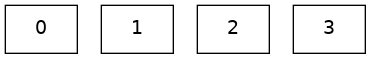

In [22]:
ddf.visualize()

## 3.3. 벙렬로 전처리 수행

n_worker = 4 로 n_thread=4 로 10,000 개시 30초, 20,000 개의 전처리시에 약 45초 걸립니다.

In [23]:
%%time

from IPython.display import display as dp
import traceback
from custom_util import remove_spec_chars

try: 
    # ddf["doc_cl"] = ddf["doc"].apply(preproces_doc, meta=('doc', 'object')).compute()      
    ddf["doc_cl"] = ddf["doc"].apply(remove_spec_chars, meta=('doc', 'object')).compute()      
    ddf["doc_cl"] = ddf["doc_cl"].apply(Okt_tokenizer,meta=('doc_cl', 'object') ).compute()      
    ddf["doc_cl"].compute()
except Exception:
    print(traceback.format_exc())    

CPU times: user 2.29 s, sys: 832 ms, total: 3.12 s
Wall time: 56.1 s


## 3.4. pandas df 로 변경

das dataframe 에서 pandas dataframe 으로 변경

In [24]:
pd_df = ddf.compute()
pd_df

,doc,doc_cl
0,"그는 ""터키 원전수주 계약은 일본 정부의 장기 위험 보증 조항에 달려 있다""고 덧붙였다.",터키 원전 수주 계약 일본 정부 장기 위험 보증 조항
1,"기재부 고위 관계자는 ""김동연 부총리가 오고 지난해 예산안 통과 과정에서 예산실이 ...",기재부 고위 관계자 김동연 부총리 지난해 예산안 통과 과정 산실 밤샘 근무 하루 예...
2,"선수들을 지도하고 있는 원동현은 ""이번 훈련을 통해 여자핸드볼 국가대표 선수들이 강...",선수 지도 동현 이번 훈련 통해 여자 핸드볼 국가대표 선수 강인하다 해병 정신 무장...
3,"광 작가도 ""게임은 거의 처음 하는 작업인데 새로운 경험이 됐다.",작가 게임 거의 처음 작업 새롭다 경험
4,"김동철 국민의당 원내대표도 강 후보자에 대해 ""도덕적 흠결도 많을뿐더러 그 흠결을 ...",김동철 국민의당 원내대표 후보자 대해 도덕 흠결 많다 흠결 자질 역량 없다 혹평 외...
...,...,...
19995,"이어 ""감독 입장에서 휴식기는 엔진을 완전히 꺼버리는 시기가 절대 아니다""며 ""휴식...",감독 입장 휴식 엔진 완전하다 시기 절대 아니다 휴식 동안 계속 엔진 후반기 선수 ...
19996,"1심 구속만기 6개월이 끝나는 10월16일 자정을 기해 반드시 석방돼야 한다""고 주...",구속 만기 개월 자정 기해 반드시 석방 주장
19997,"그는 서·최 의원에 대한 소명절차에 대해 ""그 과정은 조금 잘 안 된 걸로 알고 있...",의원 대한 소명 절차 대해 과정 조금 왜냐면 현재 국정감사 외국 때문
19998,"침묵하며 지켜보는 다수의 국민이 있다""고 말했다.",침묵 다수 국민


## 3.5. DAS Cluster 셧다운

In [25]:
import time

das_client.shutdown()
time.sleep(5)

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


## 3.6. (옵션) DAS 에러시에 아래 주석을 제거하고 작업 하세요.
- 10,000 개 실행시에 약 2분 40초 걸림

In [26]:
# %%time
        
# from custom_util import preprocess_doc

# pd_df = preprocess_doc(df)

# 4. 전처리 도입 후에 추론

전처리된 Corpus를 embedding encoding 형태로 변경

In [27]:
corpus_cl = pd_df['doc_cl'].tolist()
corpus_embeddings_cl = encode_multi_gpu_embedding(model, corpus_cl)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

## 4.1. Corpus: 전처리, Query : 전처리, 토큰 (명사, 형용사)

In [28]:
top_k = 5

queries = [
            '올 시즌 정규리그 35경기에서 23골을 작성한 손흥민은 이날 울버햄프턴을 상대로 득점에 \
            성공한 무함마드 살라흐(리버풀·23골)와 함께 정규리그 득점 공동 1위에 올랐다.\
            아시아 출신 선수가 EPL에서 득점왕에 오른 건 손흥민이 처음이다. \
            EPL뿐 아니라 유럽축구 5대 리그(잉글랜드·스페인·독일·프랑스·이탈리아)로 범위를 넓혀도 \
            아시아 선수 득점왕의 전례를 찾아보기 어렵다.'
          ]

queries = [Okt_tokenizer(queries[0])]
queries
semantic_search(model, corpus_cl, corpus_embeddings_cl, queries, top_k)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: 시즌 정규 리그 경기 작성 손흥민 울버햄프턴 상대로 득점 성공하다 무함마드 살라 리버풀 정규 리그 득점 공동 아시아 출신 선수 득점 오른 손흥민 처음 아니다 유럽 축구 리그 잉글랜드 스페인 독일 프랑스 이탈리아 범위 아시아 선수 득점 전례 어렵다

Top 5 most similar sentences in corpus:

(Score: 0.5553) 최형우 올스타전 홈런 레이스 목표 아웃 개도 같다 올스타전 경기 괜찮다 홈런 레이스 긴장
(Score: 0.5156) 영국 매체 스포츠 잉글리시 이승우 카를 레스 알레나 신비 듀오 칭찬 스페인 매체 마르카 클럽 최고 선수 이승우 알레나 득점
(Score: 0.5001) 상대 에이스 로페즈 상대로 안타 득점 대해 서도 에이스 상대로 대량 득점 기대하다 없다 필요하다 점수 다운 야구 호평
(Score: 0.4934) 경기 손흥민 구단 공식 퍼스 인터뷰 통해 준결승 웸블리 스타디움 중요하다 경기 승리 해트트릭 기록 정말 어렵다 기쁘다 승리 더욱 행복하다 소감
(Score: 0.4822) 정규 리그 우승 상태 감독 플레이오프 직행 티켓 만큼 마지막 최선 각오


In [29]:
top_k = 5

queries = [
        '삼성전자의 2분기 확정 실적이 발표된 전일부터 이틀간 증권사 18곳에서 분석 보고서를 냈다.\
        대부분은 3분기가 더 부진할 것인 데다 주가는 한 차례 더 조정이 올 것이란 어두운 전망을 내놓았다.\
        우리나라 시총 1위 기업 주식이 이런데, 미국 장으로 옮기는 데 답인가, 어깨에서 사서 무릎에 팔게 생겼다' '호실적에도 떨어지고' '오늘도 기대했던 내가 바보다 \
        증권가도 떠나는 개미들을 붙잡을 만한 전망을 내놓지 못하는 상황이다. 하반기 실적은 더 암울할 것이라는 게 중론이어서다.'
        ]


queries = [Okt_tokenizer(queries[0])]
queries
semantic_search(model, corpus_cl, corpus_embeddings_cl, queries, top_k)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: 전자 확정 실적 발표 전일 이틀 증권사 분석 보고서 대부분 부진하다 주가 차례 조정 두운 전망 우리나라 기업 주식 이렇다 미국 어깨 사서 무릎 호실 오늘 기대하다 바보 증권 가도 개미 전망 상황 하반기 실적 암울하다 중론

Top 5 most similar sentences in corpus:

(Score: 0.6207) 관련 윤여삼 미래에셋 대우 증권 연구원 브렉 시트 글로벌 여건 판단 어렵다 하반기 여건 라며 채권 매수 관점 금리 급락 전망
(Score: 0.6191) 다른 증권사 연구원 오버 이슈 상장 차례 주가 조정 조정 주식 매수 나쁘다 선택
(Score: 0.5813) 김세중 증권 투자 전략 오늘 하루 기관 펀드 유입 현금 가지 저가 매수 면서 대외 여건 잠시 진정 금요일 매물 주가 펀더 멘털 이상 판단 지적
(Score: 0.5760) 서상영 증권 연구원 한국 증시 미국 증시 강세 상회 차익 실현 매물 하락 전환 운송업 종이 전날 부진하다 미국 판매량 발표 여파 코스피 하락 주도하다 설명
(Score: 0.5498) 투자 증권 현기 연구원 결정 실망 기적 금융시장 변동성 요인 작용 라며 연말 내년 추가 양적완화 정책 대한 대감 유지 판단


# 5. Semantic Search (상품 리뷰)

- 아래의 데이터 파일은 비공개이어서, 이 섹션은 선택 입니다.

## 5.1. 데이터 준비

In [30]:
product_best_data_file = 'data/product_review/best_sample.json'

In [31]:
import json

with open(product_best_data_file) as json_file:
    best_review_data = json.load(json_file)
    
best_df = pd.DataFrame(best_review_data)
best_df.rename(columns={'contents' : 'doc'}, inplace=True)
best_df

,subject,doc
0,생으로 먹어도 익혀 먹어도 모두 어울리는 채소,"감자, 무, 고구마, 배 모두 섞인 맛이 나요.\r\n뿌리식물이라 반찬용 채소라고 ..."
1,재구매했어요^^,마늘빵을 워낙 좋아해서 마늘빵은 왠만하면 따지지않고 사는편이에요~\n후기보고 조금 ...
2,솔직히,미세먼지측정기 사면 모르고살때보다 정신적으로 더 피폐해질까봐 구입하기 망설였어요.\...
3,싱싱한 전복으로 만든 전복 크림 누들떡볶이~,"산소포장으로 싱싱하게 와서 바로 손질해서 먹었어요 크기는 왼쪽이 소, 오른쪽이 중 ..."
4,파우더라 더 먹기 좋아요 ! 편리한 아침식사,아침마다 오트밀과 귀리가루를 번갈아 가며 먹고 있어요. \r\n오버나이트 오트밀을 ...
...,...,...
95,두유 그릭 요거트 만들기,"고소한 두유 그릭 요거트 만들기\n\n매일두유는 그냥 먹어도 맛있지만,\n요거트로 ..."
96,레전드 드립 커피 선물세트 내돈내산 구매 리얼 후기!,진한 핸드 드립 커피를 집이나 사무실에서 간편하게 즐길수 있는 제품이네요 :)\r\...
97,일루마 후기,물론 여기서 이미 분유를 구매하신다는 것은 이 분유를 먹이고 계시다는 거겠죠~혹시라...
98,자연산 대왕 바지락 넣어 만든 봉골레파스타,봉골레파스타 만들어먹을 재료 주문하다\n발견한 자연산 남해안 바지락 대 사이즈!!\...


In [32]:
%%time
pd.set_option('max_colwidth', 1000)

from custom_util import preprocess_doc

best_df_cl = preprocess_doc(best_df)
best_df_cl

CPU times: user 11.5 s, sys: 45.6 ms, total: 11.5 s
Wall time: 6.84 s


,subject,doc,doc_cl
0,생으로 먹어도 익혀 먹어도 모두 어울리는 채소,"감자, 무, 고구마, 배 모두 섞인 맛이 나요.\r\n뿌리식물이라 반찬용 채소라고 생각했는데 생으로 먹어도 상큼하고 좋구요. 구워먹어도 달달하니 맛있어요. 맘 놓고 과일이나 감자, 고구마 못드시는 당뇨환자, 저탄고지 다이어터, 당질제한식 하시는 분들께 강추입니다.\r\n\r\n배처럼 잘라서 씹어먹어도 좋구요, 얇게 잘라서 잎채소와 샐러드로 먹어도 좋아요. 낯선 재료라 레시피를 검색했는데, 익히지 않고 먹는 레시피가 많아서 생으로 먹는 것이 훨 맛있나? 싶었지만... 구워 먹어도 맛있어요. \r\n\r\n저는 올리브유, 파프리카가루, 허브솔트에 버무려 두고 40분 정도 후에 팬에서 약불로 말랑해질 때까지 구웠어요. \r\n처음에는 웨지감자 마냥 짭짤하게 먹으려고 했는데, 이건 자체에 단맛이 있어서 웨지감자처럼 짭짤한 시즈닝하곤 안어울려요ㅋㅋㅋ 별로 간이 배지도 않구요. 뒤늦게 메이플시럽을 뿌려먹었더니 어울리고 좋더라구요. 익혀서 달달하게 간식용으로 드시기에 좋습니다. 고구마맛탕 같은 거 드시고 싶으신데 다이어트, 혈당 때문에 못드시는 분들은 여기다 시럽 대신에 대체감미료 사용해서 드시면 진짜 좋을 것 같아요.",감자 고구마 모두 뿌리 식물 반찬 채소 생각 생으로 상큼 좋다 달달 맛있다 과일 감자 고구마 당뇨 환자 다이어터 당질 제한 강추 이다 좋다 얇다 잎채소 샐러드 좋다 낯선 재료 레시피 검색 레시피 많다 생으로 맛있다 맛있다 올리브유 파프리카 가루 허브 솔트 무려 정도 불로 말랑하다 처음 감자 마냥 짭짤하다 자체 단맛 감자 짭짤하다 별로 간이 배지 뒤늦다 메이플시럽 좋다 달달 간식 좋다 고구마 맛탕 같다 다이어트 혈당 때문 여기 시럽 대신 대체 감미료 사용 진짜 좋다 같다
1,재구매했어요^^,"마늘빵을 워낙 좋아해서 마늘빵은 왠만하면 따지지않고 사는편이에요~\n후기보고 조금 걱정했었는데 취향에 따라 조금 갈릴순 있을것 같아요!\n시중에 바삭바삭함을 넘어서 딱딱하기까지 한 바게트는 많이 먹어봤는데 이건 아주 촉촉해요~\n저는 그래서 더 마음에 들었고, 빵 사이사이마다 버터랑\n마늘이 듬뿍듬뿍이라 아, 이런게 진짜 마늘빵이구나 싶었어요 ㅎㅎㅎ\n\n빵이 다 잘려져있지않고 끝부분은 사진처럼 컷팅이 덜\n되어있는데 그래서 빵이 떨어져있지않고 버터랑 마늘이\n더 잘흡수되고 촉촉한거 같아요!\n보통 마늘빵을 사먹으면 마늘향이 살짝 나거나\n어떤부분은 거의 바게트만 먹게되는 경우도 있는데 이건 어느 부분을 먹든 맛있어요^^\n\n사이즈는 처음 받아봤을땐 생각보다 작다 싶었는데 전 한번에 먹기에 많아서 남은건 냉동실에 보관했다가 기름 두르지 않은 팬에 살짝 데워먹었더니 맛있더라구요~\n마켓컬리에서는 전자레인지나 토스트기에 데워먹으라고 나와있어서 다음번엔 전자레인지도 한번 이용해봐야겠어요~\n\n식전빵이나 식후 디저트로도 좋고, 간식으로 먹어도 너무 맛있는 마늘바게트였어요!",마늘빵 워낙 좋아하다 마늘빵 왠만하다 편이 후기 보고 조금 걱정 취향 조금 갈릴 같다 시중 바삭바삭하다 딱딱하다 바게트 아주 촉촉하다 마음 사이사이 버터 마늘 이렇다 진짜 마늘빵 부분 사진 컷팅 버터 마늘 흡수 촉촉하다 같다 보통 마늘빵 마늘 살짝 부분 거의 바게트 경우 부분 맛있다 사이즈 처음 생각 작다 한번 먹기 많다 냉동 보관 기름 살짝 맛있다 마켓 컬리 전자레인지 토스트 다음 전자레인지 한번 이용 식전 식후 디저트 좋다 간식 맛있다 마늘 바게트
2,솔직히,미세먼지측정기 사면 모르고살때보다 정신적으로 더 피폐해질까봐 구입하기 망설였어요.\n\n그런데 밖의미세먼지보다 집안공기관리는 잘되고있을까 \n걱정이되던 찰라에 어웨어 민트 공기측정기를 컬리에서\n봤지요.\n\n온도.습도.미세먼지.화학물질\n집안의 공기질을 총체적으로 측정할수 있고 핸드폰으로\n연동이되어 지금 어떤지 집착하지않을정도로\n딱 그만큼 아는게 힘이될만큼 도움이되요.\n\n게다가 많은분들이 단점이라 생각하는\n유선밖에되지않는다라는것도\n저는 한곳에 두고 쭉 꼽아놓고 관리해서 좋아요.\n들고다니면서 공기질 미세먼지 체크하고 신경쓰고\n싶지는않거든요.\n충분히 다른어플로 알수있고 모든공간을 컨트롤하고싶진\n않아요.\n\n오늘같이 미세먼지 나쁜날 환기를안하니\n화학물질 수치가 엄청높네요.\n바깥공기는 안좋지만\n3시경 짧게환기하니\n수치가 뚝떨어져요.\n대신 초미세는 쭉 올라요. 그래프로 한눈에보이구요.\n하지만 문닫고 공청기돌리니 금방 수치회복하구요.\n역시 화학물질배출은 환기가 답인가봐요.\n \n집에따로 환풍시설이 없어서 환기타임 언제나\n전전긍긍하는데. \n적당히 조절할수있게 우리집 공기관리 도움받아서\n너무좋으네요.,미세먼지 측정기 사면 고살 정신 폐해 구입 미세먼지 집안 관리 걱정 웨어 민트 측정기 컬리 온도 습도 미세먼지 화학물질 집안 기질 체적 측정 핸드폰 연동 지금 어떻다 집착 정도 도움 게다가 많다 단점 생각 유선 꼽아놓 관리 좋다 기질 미세먼지 체크 신경 충분하다 어플 공간 컨트롤 오늘 미세먼지 나쁘다 환기 화학물질 수치 높다 바깥 공기 안좋다 짧다 환기 수치 대신 미세 그래프 한눈 청기 금방 수치 회복하다 역시 화학물질 배출 환기 시설 없다 환기 타임 전전긍긍 적당하다 조절 우리 공기 관리 도움 좋다
3,싱싱한 전복으로 만든 전복 크림 누들떡볶이~,"산소포장으로 싱싱하게 와서 바로 손질해서 먹었어요 크기는 왼쪽이 소, 오른쪽이 중 사이즈인데 비교해봤을때 아주 큰차이는 없어요 그만큼 소짜리도 그리 작지 않아서 괜찮더라구요\n\n\n유튜브에서 먹방보다가 ㅎㅎ 도로시님이 드신 요리보고 따라해봤어요.\n\n준비물:불린 중국당면,크림소스,우유,후추,젓가락떡,새우,전복,양파,청양고추\n\n올리브유를 두르고 양파,새우,손질한 전복을 같이 볶아줍니다. 새우 색이 변할 때 우유 200~250ml정도와 크림소스를 듬뿍 넣어주고 해동시킨 젓가락 떡과 미리 불려둔 중국당면을 넣어줍니다.\n\n*중국당면은 조리시 미리 뜨거운물에 데쳐도 되지만 찬물에 반나절 불려두는게 더 쫄깃하고 맛있어요.\n\n느끼하지않게 후추를 조금 뿌려주고 약불에 5분~7분정도 끓입니다. 너무 오래끓여도 당면이나 떡의 쫄깃함이 사라지니 주의!\n다 끓으면 불을끄고 위에 미리 썰어둔 청양고추를 넣어먹으면 돼요\n\n 전복죽이나 전복버터구이말고 뭐할까하다가 유튜브에서 보고 바로 해봤는데 정말 맛있어요 크림소스랑 전복이랑 생각외로 정말 잘어울리고 당면,떡, 전복 모두 쫄깃한 식감이 일품이에요~~\n위에 청양고추를 썰어넣어선지 느끼하지않아 더욱 입맛에 맞았어요ㅎㅎ",산소 포장 싱싱하다 바로 손질 크기 왼쪽 오른쪽 사이즈 비교 아주 없다 리도 작다 괜찮다 유튜브 먹방 도로시 요리 보고 준비물 중국 당면 크림소스 우유 후추 젓가락 새우 전복 양파 청양고추 올리브유 양파 새우 손질 전복 새우 변하다 우유 정도 크림소스 듬뿍 해동 젓가락 미리 중국 당면 중국 당면 조리 미리 뜨겁다 찬물 반나절 쫄깃 맛있다 느끼하다 후추 조금 당면 쫄깃함 주의 미리 청양고추 전복죽 전복 버터 구이 유튜브 보고 바로 정말 맛있다 크림소스 전복 생각 외로 정말 당면 전복 모두 쫄깃 식감 일품 청양고추 선지 느끼하다 더욱 입맛
4,파우더라 더 먹기 좋아요 ! 편리한 아침식사,"아침마다 오트밀과 귀리가루를 번갈아 가며 먹고 있어요. \r\n오버나이트 오트밀을 좋아하긴 하지만 밤마다 만드는게 가끔은 귀찮을 때도 있어서 컬리에서 귀리가루까지 구매해 \r\n하루하루 번갈아가며 먹습니다. 밀싹은 좋다는 이야기 알고 있었고 최근 운동을 시작했고 환절기라 영양소가 필요해 \r\n 꼭 먹어야겠다 생각했지만 주스로 구매하자니 소비하는 양과 비용도 크고 무엇보다 요즘 건강주스에 대한 말이 많아서 구매가 좀 꺼려지는 시점 이었어요. \r\n그러던 중 컬리에서 요녀석을 찾게 되었고, 고마운 후기들 몇 번 정독하고 구매했습니다. \r\n\r\n과일과 채소로 스무디만들어 갈아마시면 더 좋겠지만 아직까지는 그렇게 부지런하진 못했고요 ㅠ ㅋㅋ\r\n지금은 귀리우유를 만들어 먹거나 오버나이트 오트밀을 만들 때 1스푼씩 넣어주고 있습니다. \r\n동결건조 방식도 마음에 들고 무엇보다 먹기 편해서 챙기기 정말 좋아요. 

## 5.2. Corpus: 원문, Query : 원문

In [33]:
corpus = best_df_cl['doc'].tolist()
corpus_pd_review_embeddings = encode_multi_gpu_embedding(model, corpus)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [34]:
    
top_k = 3

queries = [ '가격 : 할인가 개당 3,720원 (2개 이상 구입 필수) 양 : 1인분으로 평범한 양, \
            점심에 먹는 것을 추천 조리시간 및 난이도 : 약 7분, 라면 끓이는 수준의 난이도 평가 : 시중에 파는 \
            우동이 2천원대라는 점을 비교하면 3천원대로 나름 고급형 우동을 집에서 편하게 먹을 수 있어요. \
            어묵 사이즈는 여성 손바닥 정도이고, 한장 크게 들어가있어서 먹으면서 잘라 먹거나 베어 먹으면 됩니다. \
            국물과 어묵이 맛있어서 우동면 하나도 남기지 않고 다 먹었어요. \
            고추우동이라서 살짝 매콤한가 했는데 전혀 맵지 않고 칼칼함도 없이 시원하고 짭쫄한 맛입니다. \
            조리 방법은 뒷면에 상세하게 나와있어서 라면 끓일 줄 아는 분들이면 쉽게 따라할 수 있을거에요. \
            저는 설명서에 다른 채소와 함께 끓이면 더 맛있다고 하여 알배기배추 작은 거 추가해줬더니 씹는 맛이 일품이네요. \
            냉장고에 남는 채소 있으면 같이 끓이시는 것 추천! 맛있게 잘 먹었습니다 :)'
          ]
# queries = [Okt_tokenizer(queries[0])]
# queries
semantic_search(model, corpus, corpus_pd_review_embeddings, queries, top_k)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: 가격 : 할인가 개당 3,720원 (2개 이상 구입 필수) 양 : 1인분으로 평범한 양,             점심에 먹는 것을 추천 조리시간 및 난이도 : 약 7분, 라면 끓이는 수준의 난이도 평가 : 시중에 파는             우동이 2천원대라는 점을 비교하면 3천원대로 나름 고급형 우동을 집에서 편하게 먹을 수 있어요.             어묵 사이즈는 여성 손바닥 정도이고, 한장 크게 들어가있어서 먹으면서 잘라 먹거나 베어 먹으면 됩니다.             국물과 어묵이 맛있어서 우동면 하나도 남기지 않고 다 먹었어요.             고추우동이라서 살짝 매콤한가 했는데 전혀 맵지 않고 칼칼함도 없이 시원하고 짭쫄한 맛입니다.             조리 방법은 뒷면에 상세하게 나와있어서 라면 끓일 줄 아는 분들이면 쉽게 따라할 수 있을거에요.             저는 설명서에 다른 채소와 함께 끓이면 더 맛있다고 하여 알배기배추 작은 거 추가해줬더니 씹는 맛이 일품이네요.             냉장고에 남는 채소 있으면 같이 끓이시는 것 추천! 맛있게 잘 먹었습니다 :)

Top 3 most similar sentences in corpus:

(Score: 0.8656) 요즘 코로나 때문에 외식하기 참 어렵죠?
그래서 이번주에는 외식분위기를 느끼고자 ‘중식’으로 메뉴를 정하고 우리 가족이 충분히 먹을수 있는
요리재료를 컬리에서 주문했어요.

자 그럼 주문한 재료를 가지고 맛있게 요리를 만들어서 집에서 외식을 해 보아요~

컬리에서 주문한 요리재료 : 찹쌀탕수육, 어향육슬, 닭다리살깐풍기, 초마짜장면
  * 그리고 컬리에서 산 강대인 쌀과 [가농바이오]오메가에그1+등급 특란으로 볶음밥도 만들었어요.

요리는 
 1. 탕수육과 깐풍기를 오븐 또는 에어프라이어에 넣고 맛있게 데웁니다.
 2. 탕수육 소스는 취향에 맞게  파인애플을 추가해서 새콤달콤하게 만들어 줍니다.
 3. 깐풍기 소스를 만들어서 준비합니다.
 4. 짜장면

## 5.3. Corpus: 전처리, Query : 전처리, 토큰 (명사, 형용사)

In [35]:
corpus_cl = best_df_cl['doc_cl'].tolist()
corpus_pd_review_embeddings_cl = encode_multi_gpu_embedding(model, corpus_cl)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [36]:
    
top_k = 3

queries = [ '가격 : 할인가 개당 3,720원 (2개 이상 구입 필수) 양 : 1인분으로 평범한 양, \
            점심에 먹는 것을 추천 조리시간 및 난이도 : 약 7분, 라면 끓이는 수준의 난이도 평가 : 시중에 파는 \
            우동이 2천원대라는 점을 비교하면 3천원대로 나름 고급형 우동을 집에서 편하게 먹을 수 있어요. \
            어묵 사이즈는 여성 손바닥 정도이고, 한장 크게 들어가있어서 먹으면서 잘라 먹거나 베어 먹으면 됩니다. \
            국물과 어묵이 맛있어서 우동면 하나도 남기지 않고 다 먹었어요. \
            고추우동이라서 살짝 매콤한가 했는데 전혀 맵지 않고 칼칼함도 없이 시원하고 짭쫄한 맛입니다. \
            조리 방법은 뒷면에 상세하게 나와있어서 라면 끓일 줄 아는 분들이면 쉽게 따라할 수 있을거에요. \
            저는 설명서에 다른 채소와 함께 끓이면 더 맛있다고 하여 알배기배추 작은 거 추가해줬더니 씹는 맛이 일품이네요. \
            냉장고에 남는 채소 있으면 같이 끓이시는 것 추천! 맛있게 잘 먹었습니다 :)'
          ]
queries = [Okt_tokenizer(queries[0])]
queries
semantic_search(model, corpus, corpus_pd_review_embeddings, queries, top_k)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: 가격 할인 이상 구입 필수 인분 평범하다 점심 추천 조리 시간 난이도 라면 수준 난이도 평가 시중 우동 비교 나름 고급 우동 편하다 어묵 사이즈 여성 손바닥 정도 한장 크게 국물 어묵 맛있다 우동 하나 고추 우동 살짝 매콤 전혀 칼칼하다 시원하다 짭쫄 이다 조리 방법 상세 라면 이면 설명 다른 채소 맛있다 배기 배추 작다 추가 일품 냉장고 채소 추천 맛있다

Top 3 most similar sentences in corpus:

(Score: 0.7101) 물론 요리 하지 않고 그냥 먹어도 너무나도 맛있어요. 한봉지는 그냥 뚝딱 이지요ㅎㅎ 
그렇지만 요리에 넣어서 먹으면 더욱 더 맛있답니다.
아*백 에서 너무 맛있는ㅎㅎ 하지만 코코넛 새우먹으러 가기에는....ㅠㅠ
그래서 집에서 요 코코넛으로 만들어 보았답니다!!^^
바삭바삭 너무나도 맛있어요~ 기름을 쓰지 않고 오븐에 구워서 건강에도 좋답니다^^

새우는 20개정도 준비했답니다. 계란 1개, 빵가루 1/4컵, 코코넛칩1/4컵 (약간 부숴주었어요~), 소금, 후추, 전분가루
냉동새우였기에 물기를 쫙~ 빼준 후에 준비해줍니다^^(키친타올도 닦아도 좋아요!)
새우에 소금과 후추로 약간 간을 한 후 전분가루를 뭍혀줍니다(위생팩 안에 넣고 흔들어주면 더 쉬워요^^
계란물에 새우를 퐁당 넣은 후에
코코넛칩과 빵가루 옷을 입혀줍니다^^

오일스프레이를 뿌린 후에 (기름기 없는 것을 원하시면 안뿌려도 됩니다.) 180도 예열한 오븐에 10분, 뒤집어서 10분하면
바삭바삭 달콤 맛있는 코코넛 쉬림프 완성!

만들기도 너무 쉽지만, 코코넛 칩으로 인해 바삭하고 너무 맛있어요^^
(Score: 0.7057) ☆좋은점: 주말에 집에서 맛난 식당 요리를 편하게 먹을수 있다는 점이 좋아요. 해놓은 반찬 없을때 후다닥, 일 끝나고 집에와서 손쉽게

♧양: 넉넉합니다. 남편과 2명이서 먹었는데 배불렀어요. 

♧맵기정도: 맵지 않아요. 심심해서 김치나 다른 반찬과 먹어도 부담없어요. 전 파김치랑 먹었어요. 김에 싸먹어도 

## 5.4. Non-Best Review (???) - Corpus: 전처리, Query : 전처리, 토큰 (명사, 형용사)

In [37]:
    
top_k = 3

queries = [ '매콤어묵도 깔끔한 맛이에요']
queries = [Okt_tokenizer(queries[0])]
queries
semantic_search(model, corpus, corpus_pd_review_embeddings_cl, queries, top_k)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: 매콤 어묵 깔끔하다

Top 3 most similar sentences in corpus:

(Score: 0.3305) 무설탕에 과일 원육 70% 이상을 담은 잼이라고 해서 사봤어요.
조금은 건강한 맛일 거라고 예상했는데 너무 달지 않으면서도 상큼하고 적당히 달달한 맛이 기존의 잼보다 저는 훨씬 마음에 들어요.
달기만 하고 과일 원육의 씹는 맛이 없다던가 하는 등의 단점이 기존 잼에 있었다면
이건 상큼하고 달콤하면서도 과육의 씹는 맛이 있어서 먹는 재미가 있어요.
그야말로 건강도 챙기고 맛도 챙길 수 있는 제품인 것 같아요.
잼 활용도야 워낙 많겠지만 저는 요즘 주로 요거트에 넣어 먹거나 간단하게 티푸드로 만들어 먹어요.
수제 요거트에 견과류  적당히 넣고 멘즈앤가서 잼을 기호에 따라 넣고 섞어서 먹으면 적당히 달콤하면서도 상큼한 맛을 즐길 수 있어요.
그리고 집에 있는 식빵을 밀대로 밀어서 납작하게 만들고 쨈을 바른 후 롤케잌처럼 돌돌돌 말아서 랩으로 감싼 후 먹기 좋은 크기로 썰어서 먹으면
아이들 간식이나 티푸드로 정말 좋아요. 이때 기호에 따라 슬라이스 치즈를 함께 넣어도 좋아요.
이번에 처음 이 제품 사봤는데 너무너무 마음에 들어서 종류대로 다 사보고 싶을 정도예요.
상큼하고 너무 달지 않는 잼 찾는다면 꼭 추천하고 싶은 제품이에요 ^^
(Score: 0.3278) 요거 물건이네요~ 일단 가격대비 알차단 생각이 들었습니다. 밀가루도 없고 설탕 대신 천연감미료(?)도 쓰고.. 원료 신경써서 쓴 게 티가 나요. 2개나 들어있으니 뭐 괜찮은 듯

빵 워낙 좋아하다보니 어떻게 먹을까~ 했는데, 일단 그냥 먹어도 너무 맛있구요. 요거트향이 예상보다 확 올라오면서 나름 맛 진하고 색깔도 노릇노릇 에그타르트?마냥 먹음직스럽고 실제로도 맛있어요! 단백질 많다보니 퍽퍽할까 했는데 제 기준으로는 충분히 촉촉하고 일단 2개 다 먹으면 꽤나 포만감이 있어 다이어트에도 좋을 것 같네요! 

식사대용으로 하려다보니 이것저것 해 봤는데, 일단 무설탕 샹달프잼하고

In [38]:
    
top_k = 3

queries = [ '한개가 간장소스가 다 터져서 문의글 남기면서 보니, \
            간장 터져서 왔다는 글이 많이 보이네요. 맛있는데 불안해서 또 시킬 수 있을지 모르겠네요ㅜㅜ'
          ]
queries = [Okt_tokenizer(queries[0])]
queries
semantic_search(model, corpus, corpus_pd_review_embeddings_cl, queries, top_k)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: 간장 소스 문의 간장 맛있다 불안하다

Top 3 most similar sentences in corpus:

(Score: 0.4653) 첫 출산 후 4개월째, 아이 돌보느라 식사도 불규칙적이고 잘 챙겨먹지 못해 아침이면 몸이 너무 힘들었는데요, 

반신반의로 시험삼아 먹어봤는데 정말 상큼하고 맛있어요!

남편은 기분탓이라고 하는데ㅋ 오늘 아침에 마셔봤더니 피로감이 가시면서 몸에 생기가 도는 느낌이예요~

처음 맛본 "Beat the Day" - 비트, 당근, 사과, 레몬 - 어렸을 때 엄마가 아침에 갈아줬던 당근사과 주스랑 비슷한 맛이었어요

왠지 모르겠는데 어렸을 때 먹었던 엄마표 주스맛이 확 떠오르더라구요:) 

그만큼 건강한 맛인가 같고 양도 생각보다 괜찮았어요

집에 있는 500미리 탄산수랑 용량 비교샷 같이 올려요~ 

타사랑 비교해보니 타사제품은 1일 클렌즈 450ml x 6병이라 가격이 높고, beginner 입에 안맞을 수도 있는 가능성을 고려해서 종합적으로  고민 끝에 가격/용량 + 샛별 배송때문에 콜린스 그린 선택했네요- 

1일 클렌즈 해보고 몸 상태가 좋아지면 더 주문하고 싶네요! 


(Score: 0.4353) 제가 성게알을 즐길 줄 아는 사람이 못 되어요,
그래서 성게알을 먹어본 경험도 거의 가물가물...
그런데 며칠 전부터 갑자기! 뜬금없이!
성게알이 넘 먹고 싶은 거예요ㅎㅎ 맛도 기억 안 나면서 말이에요.
초밥 단품으로라도 먹어야겠다 했는데
자꾸 기회가 안 닿아서, 그냥 컬리에서 주문했어요.

역시 아직 저에게 성게알 자체는 어려운 음식이더라고요 ^^;
집에 들기름만 있었어도 좀 달랐을까 싶은데,
밥이랑 아보카도 오일이랑 그렇게만으로는 별맛을 못 느꼈어요.
그래서 해산물과 잘 어울리는 크림 파스타에 투척!
소스는 크림에 닭육수를 조금 섞어서 끓였어요.
냉동실에 있던 새우도 넣고~ 다진 마늘도 넣고~
바다냄새 더 많이 나라고 감태가루도 솔솔 뿌리고~
크림소스가 면에 끈적끈적하게 붙도록 졸여서
성게알을 곁들여서 완

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


2022-08-15 10:55:35 - _GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
